In [1]:
!pip install datasets transformers livelossplot &> null

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from transformers import RobertaForTokenClassification, RobertaTokenizer
from sklearn import metrics
from datasets import load_dataset
from livelossplot import PlotLosses
import tqdm
tqdmn = tqdm.notebook.tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset = load_dataset("conll2003")
num_labels = dataset['train'].features['ner_tags'].feature.num_classes
labels = dataset['train'].features['ner_tags'].feature

label2id = {str(id): val for id, val in enumerate(labels.names)}
id2label = {v: k for k, v in label2id.items()}
label2id

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6. Subsequent calls will reuse this data.


{'0': 'O',
 '1': 'B-PER',
 '2': 'I-PER',
 '3': 'B-ORG',
 '4': 'I-ORG',
 '5': 'B-LOC',
 '6': 'I-LOC',
 '7': 'B-MISC',
 '8': 'I-MISC'}

In [ ]:
dataset['train']


Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

In [4]:
dataset['test']


Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 3453
})

In [ ]:
bert_version = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(bert_version)

def encode(example):
    encodings = tokenizer(example['tokens'], truncation=True, padding='max_length', is_split_into_words=True)
    labels = example['ner_tags'] + [0] * (tokenizer.model_max_length - len(example['ner_tags']))
    return { **encodings, 'labels': labels }

dataset = dataset.map(encode)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63ba56944e35c1943434322a07ceefd79864672041b7834583709af4a5de4664/cache-8a9ed0a78cc9a5a3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63ba56944e35c1943434322a07ceefd79864672041b7834583709af4a5de4664/cache-1b47d480915d19af.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63ba56944e35c1943434322a07ceefd79864672041b7834583709af4a5de4664/cache-ae4b81120f954941.arrow


In [ ]:
data = dict()
data['train'] = torch.utils.data.DataLoader(dataset['train'], batch_size=4)
data['validation'] = torch.utils.data.DataLoader(dataset['validation'], batch_size=4)


def train_model(model, optimizer, num_epochs=5, batch_size=4):    
    train_loss = []
    curr_loss = {}
    liveloss = PlotLosses()
    # for epoch in tqdmn(range(num_epochs)):

    for epoch in range(num_epochs):
        current_loss = 0
        # for i, batch in enumerate(tqdmn(train_data)):
        for i, batch in enumerate(data['train']):
            model.train().to(device)
            batch = { k: v.to(device) for k, v in batch.items() }
            outputs = model(**batch)
            loss = outputs[0]
            loss.backward()

            current_loss += loss.item()
            if i % 8 == 0 and i > 0:
                optimizer.step()
                optimizer.zero_grad()
                train_loss.append(current_loss / 32)
                
                curr_loss['train loss'] = current_loss/32
                liveloss.update(curr_loss)
                liveloss.send()
                current_loss = 0

            if i%1000 == 0 and i>0:
                model.eval()
                validation_loss = 0
                for i, batch in enumerate(data['validation']):
                    batch = { k: v.to(device) for k, v in batch.items() }
                    outputs = model(**batch)
                    loss = outputs[0]
                    validation_loss += loss.item()
                curr_loss['validation loss'] = validation_loss/(i*4)
                liveloss.update(curr_loss)
                liveloss.send()


        optimizer.step()
        optimizer.zero_grad()


In [ ]:
model = RobertaForTokenClassification.from_pretrained(bert_version, num_labels=len(label2id))
model.config.id2label = id2label
model.config.label2id = label2id

model.train().to(device)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

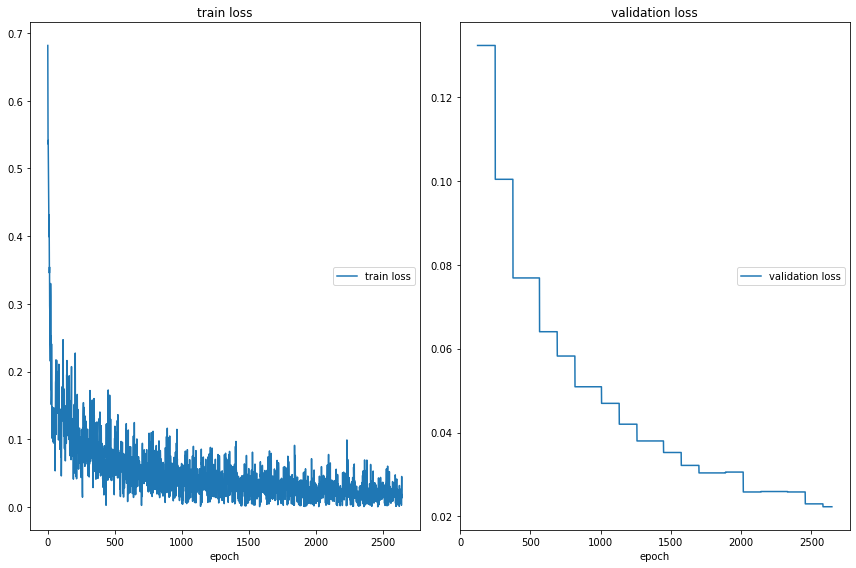

train loss
	train loss       	 (min:    0.000, max:    0.682, cur:    0.018)
validation loss
	validation loss  	 (min:    0.022, max:    0.132, cur:    0.022)


In [ ]:
train_model(model, optimizer, num_epochs=6)

In [ ]:
model_loc = "/content/drive/My Drive/ner-6e.pth"
torch.save(model, model_loc)


In [ ]:
### test model

model = model.eval()
test_data = torch.utils.data.DataLoader(dataset['test'], batch_size=4)

confusion = torch.zeros(num_labels, num_labels)
y_true, y_pred = [], []
for i, batch in enumerate(tqdmn(test_data)):
    with torch.no_grad():
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model(**batch)
            
    s_lengths = batch['attention_mask'].sum(dim=1)
    for idx, length in enumerate(s_lengths):
        true_values = batch['labels'][idx][:length]
        pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
        y_true.extend(true_values)
        y_pred.extend(pred_values)
        for true, pred in zip(true_values, pred_values):
            confusion[true.item()][pred.item()] += 1


              precision    recall  f1-score   support

           0      0.984     0.982     0.983     59130
           1      0.836     0.806     0.821      1617
           2      0.795     0.817     0.806      1156
           3      0.860     0.775     0.815      1661
           4      0.777     0.835     0.805       835
           5      0.805     0.841     0.823      1668
           6      0.749     0.860     0.801       257
           7      0.653     0.726     0.688       702
           8      0.516     0.681     0.587       216

    accuracy                          0.961     67242
   macro avg      0.775     0.814     0.792     67242
weighted avg      0.962     0.961     0.961     67242



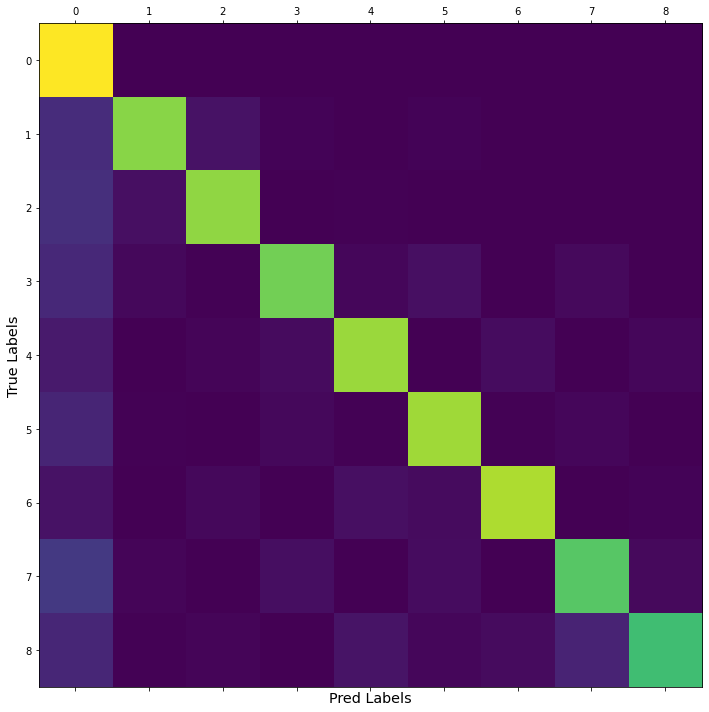

In [ ]:
y_pred = list(map(int, y_pred))
y_true = list(map(int, y_true))
for i in range(num_labels):
    confusion[i] = confusion[i] / confusion[i].sum()
  
print(metrics.classification_report(y_true, y_pred, digits=3))



fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confusion.numpy())

labels = list(label2id.keys())
ids = np.arange(len(labels))
ax.set_ylabel('True Labels', fontsize='x-large')
ax.set_xlabel('Pred Labels', fontsize='x-large')
ax.set_xticks(ids)
ax.set_xticklabels(labels)
ax.set_yticks(ids)
ax.set_yticklabels(labels)

fig.tight_layout()
plt.show()

In [ ]:
test_string = "He travelled to New Yorkshire".split(" ")
test_sample = [test_string]

sample = tokenizer(test_sample, truncation=True, padding='max_length', is_split_into_words=True)
for k, v in sample.items():
  sample[k] = torch.tensor(sample[k])

batch = { k: v.to(device) for k, v in sample.items() }
outputs = model(**batch)

print(outputs)
print(type(outputs))
print(outputs.logits)

pred_classes = map(int, torch.argmax(outputs.logits, dim=2)[idx][:len(test_string)])
for word, pred in zip(test_string, pred_classes):
    print(word, label2id[str(pred)])

TokenClassifierOutput(loss=None, logits=tensor([[[ 9.6803, -0.4831, -2.2509,  ..., -1.8652, -0.6435, -1.6912],
         [ 9.9908, -0.9090, -1.5312,  ..., -1.3522, -1.0335, -1.4573],
         [ 9.9451, -0.9579, -1.9314,  ..., -1.5620, -0.8744, -1.5987],
         ...,
         [ 9.6705, -0.4765, -2.2551,  ..., -1.8774, -0.6264, -1.6939],
         [ 9.6705, -0.4765, -2.2551,  ..., -1.8774, -0.6264, -1.6939],
         [ 9.6705, -0.4765, -2.2551,  ..., -1.8774, -0.6264, -1.6939]]],
       device='cuda:0', grad_fn=<AddBackward0>), hidden_states=None, attentions=None)
<class 'transformers.modeling_outputs.TokenClassifierOutput'>
tensor([[[ 9.6803, -0.4831, -2.2509,  ..., -1.8652, -0.6435, -1.6912],
         [ 9.9908, -0.9090, -1.5312,  ..., -1.3522, -1.0335, -1.4573],
         [ 9.9451, -0.9579, -1.9314,  ..., -1.5620, -0.8744, -1.5987],
         ...,
         [ 9.6705, -0.4765, -2.2551,  ..., -1.8774, -0.6264, -1.6939],
         [ 9.6705, -0.4765, -2.2551,  ..., -1.8774, -0.6264, -1.6939],
 

In [ ]:
test_string = "Apple unveiled the macbook pro".split(" ")
test_sample = [test_string]

sample = tokenizer(test_sample, truncation=True, padding='max_length', is_split_into_words=True)
for k, v in sample.items():
  sample[k] = torch.tensor(sample[k])

batch = { k: v.to(device) for k, v in sample.items() }
outputs = model(**batch)

print(outputs)
print(type(outputs))
print(outputs.logits)

pred_classes = map(int, torch.argmax(outputs.logits, dim=2)[idx][:len(test_string)])
for word, pred in zip(test_string, pred_classes):
    print(word, label2id[str(pred)])

TokenClassifierOutput(loss=None, logits=tensor([[[-0.6316,  0.0716, -2.7365,  ..., -3.0754,  0.9464, -2.5171],
         [ 7.7478, -1.4211, -1.4322,  ..., -1.3382, -0.5878, -0.8446],
         [ 9.8347, -1.1529, -1.9606,  ..., -2.0074, -0.2019, -1.3738],
         ...,
         [ 0.1614, -0.3192, -2.6715,  ..., -2.9941,  1.4340, -2.2198],
         [ 0.1614, -0.3192, -2.6715,  ..., -2.9941,  1.4340, -2.2198],
         [ 0.1614, -0.3192, -2.6715,  ..., -2.9941,  1.4340, -2.2198]]],
       device='cuda:0', grad_fn=<AddBackward0>), hidden_states=None, attentions=None)
<class 'transformers.modeling_outputs.TokenClassifierOutput'>
tensor([[[-0.6316,  0.0716, -2.7365,  ..., -3.0754,  0.9464, -2.5171],
         [ 7.7478, -1.4211, -1.4322,  ..., -1.3382, -0.5878, -0.8446],
         [ 9.8347, -1.1529, -1.9606,  ..., -2.0074, -0.2019, -1.3738],
         ...,
         [ 0.1614, -0.3192, -2.6715,  ..., -2.9941,  1.4340, -2.2198],
         [ 0.1614, -0.3192, -2.6715,  ..., -2.9941,  1.4340, -2.2198],
 